# lassoCV

This notebook demonstrates how to conduct Lasso with stratified K fold cross validation
on the Calling Cards data.  

## Pulling the data

The calling cards data should now strictly be taken from data source 'brent_nf_cc'. All
of the Mitra data has been reprocessed through the nf-core/callingcards:1.0.0 pipeline.  

Where there are multiple replicates, they have been aggregated. The `deduplicate`
parameter to `PromoterSetSigAPI()` selects aggregated data where it exists. Where
there is a single passing replicate, that replicate is used.

## Setup

As usual, import the `yeastdnnexplorer` interface functions

In [ ]:
import patsy as pt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, clone
from sklearn.utils import resample

from yeastdnnexplorer.interface import *

# configure the logger to print to console
import logging

logging.basicConfig(level=logging.DEBUG)

pss_api = PromoterSetSigAPI()
expression_api = ExpressionAPI()

## Pull the deduplicated calling cards data

This will pull all of the currently usable data. In the future, we will remove 
"unreviewed". This will take a minute or two as it will need to fetch all of the
underlying data

In [ ]:
pss_api.push_params(
    {
        "source_name": "brent_nf_cc",
        "deduplicate": "true",
        "data_usable": ["unreviewed", "pass"],
    }
)

pss_res = await pss_api.read(retrieve_files=True)

## Pull the corresponding perturbation data

In this case, we are pulling the McIsaac data. In order to label blacklisted genes,
we'll need the shrunken data. For modelling, we will use the unshrunken data.

In [ ]:
expression_api.push_params(
    {
        "regulator_symbol": ",".join(
            pss_res.get("metadata").regulator_symbol.unique().tolist()
        ),
        "source_name": "mcisaac_oe",
        "time": "15",
    }
)

expression_res_shrunken = await expression_api.read(retrieve_files=True)

# this will add the effect_colname parameter to the expression API
expression_api.push_params(
    {
        "effect_colname": "log2_ratio",
    }
)

expression_res_unshrunken = await expression_api.read(retrieve_files=True)



## Transform the data into a usable format for modelling

Note that there are new functions, `metric_arrays` and'
`negative_log_transform_by_pvalue_and_enrichment`. See the API section of this
documentation for more details.  

You will likely want to save the results of this cell so that you do not have to run
the DB or transformation steps in future sessions, unless of course you need or want
to update the your data.

In [ ]:
# extract the data to a more managable format using `metric_arrays`

X = metric_arrays(
    pss_res,
    {"poisson_pval": np.min, "callingcards_enrichment": np.max},
)

Y = metric_arrays(
    expression_res_unshrunken,
    {"effect": np.max},
)

Y_shrunken = metric_arrays(
    expression_res_shrunken,
    {"effect": np.max},
)

# define a set of common genes between X and y
common_genes = X["poisson_pval"].index.intersection(
    Y.get("effect", pd.DataFrame()).index
)

# binarize the Y.get("effect") DataFrame as True if the value is not 0
# We wish to exclude any genes that are always unresponsive
Y_binary = Y_shrunken.get("effect", pd.DataFrame()).eq(0)

# define blacklisted genes as those records where they are labeled "unresponsive"
# in all columns
blacklisted_genes = Y_binary[Y_binary.all(axis=1)].index.intersection(common_genes)

# remove the blacklist genes from Y and retain only common genes
Y_filtered = Y.get("effect", pd.DataFrame()).loc[common_genes].drop(blacklisted_genes)

# remove the blacklisted_genes for X and retain only the common genes
X_filtered = {}
for key in X.keys():
    X_filtered[key] = X[key].loc[common_genes].drop(blacklisted_genes)

# Next, transform the X object into a predictors_df using the shifted negative log rank
# transformation. See `negative_log_transform_by_pvalue_and_enrichment` for more
# details
scores_list = [
    negative_log_transform_by_pvalue_and_enrichment(
        X_filtered["poisson_pval"].loc[:, i],
        X_filtered["callingcards_enrichment"].loc[:, i],
    )
    for i in X_filtered["poisson_pval"].columns
]

# Convert the list of scores into a DataFrame
predictors_df = pd.DataFrame(scores_list).T

# Set the index and columns to match X_filtered["poisson_pval"]
predictors_df.index = X_filtered["poisson_pval"].index
predictors_df.columns = X_filtered["poisson_pval"].columns


# conduct a similar shifted negative log rank transformation on the Y values
Y_filtered_ranked = Y_filtered.rank(ascending=False, method="average")
Y_filtered_transformed = Y_filtered_ranked.apply(shifted_negative_log_ranks, axis=0)

## Helper functions

These are drafts of functions to run LassoCV and bootstrap_lassoCV. They parse the
data into a response dataframe (single column dataframe) and predictor dataframe using
a formula via patsy. There is a function that will use the data to generate the bins
for StratifiedKFold. `interaction_modeling` runs the LassoCV over those folds (though
any estimator with a `cv` method would work in this function). Finally,
`boostrap_lassoCV` is an implementation of the bootstrap for the Lasso based on 
Hastie et al.
[Statistical Learning with Sparsity](https://hastie.su.domains/StatLearnSparsity/). See
chapter 6.2.  

These functions and their design is not yet clear in my mind, hence including them here
rather than in the source code. The purpose will be to move them into source once we
have a clear sense of how they will be used.

**NOTE**: There is currently an expectation in these functions that there may be
replicates in the response data with the suffix _rep\d, eg `CBF1_rep2`, but that there
are no replicates in the binding data. This is not well handled and needs to be treated
with care.

In [5]:
import re
from typing import Tuple, Union, Dict
from sklearn.linear_model import Lasso

def generate_modeling_data(
    colname: str,
    response_df: pd.DataFrame,
    predictors_df: pd.DataFrame,
    drop_intercept: bool = True,
    formula: str = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generate the response and predictor data

    :param colname: The column name to use as the response variable. This column name
        should exist in `response_df` and predictors_df
    :param response_df: The transformed response variable DataFrame
    :param predictors_df: The predictors DataFrame
    :param drop_intercept: Whether to drop the intercept in the formula. This adds
        a -1 to the formula if True. See the patsy docs
        https://patsy.readthedocs.io/en/latest/formulas.html#intercept-handling
    :param formula: The formula to use for the interaction model. If None, the formula
        will be generated automatically. The formula should be in the form of
        `colname_LRR ~ predictor1 + predictor2 + ... + predictorN`. If `drop_intercept`
        is True, a -1 will be added to the formula. Note that _LRR needs to be added
        to the response variable name in the formula.

    :return: A tuple of the response variable DataFrame and the predictors DataFrame

    :raises ValueError: If `colname` does not exists in `predictors_df`
    :raises ValueError: if all of the columns in `response_df` are not present in
        `predictors_df`
    """
    # Validate input
    if colname not in response_df.columns:
        raise ValueError(f"The column {colname} does not exist in the response DataFrame.")
    # get any column in response_df that is not in predictors_df.
    # If there are any, raise an error and print the columns that are not in predictors_df
    # Remove the pattern "_rep\d+" from the column names
    response_columns = response_df.columns.str.replace(r'_rep\d+', '', regex=True)
    # Find the missing columns, if any
    missing_cols = response_columns.difference(predictors_df.columns)
    if not missing_cols.empty:
        raise ValueError("The following columns are missing from "
                        f"the predictors DataFrame: {missing_cols}")

    tmp_df = predictors_df.copy()
    tmp_df[f"{colname}_LRR"] = response_df[colname]

    # Step 2: Drop the row where index matches `colname` if it exists
    if colname in tmp_df.index:
        tmp_df = tmp_df.drop(index=colname)

    # Step 3: Define the interaction formula
    perturbed_tf = re.sub(r'_rep\d+', '', colname)
    if formula is None:
        interaction_terms = " + ".join(
            [
                f"{perturbed_tf}:{other_col}"
                for other_col in predictors_df.columns
                if other_col != perturbed_tf
            ]
        )
        formula = f"{colname}_LRR ~ {perturbed_tf} + {interaction_terms}"
    
    if drop_intercept:
        formula += " - 1"

    # Step 4: Generate X, y matrices with patsy
    y, X = pt.dmatrices(formula, tmp_df, return_type="dataframe")

    y.columns = y.columns.str.replace('_LRR', '')

    return y, X

def stratification_classification(
        binding_vector: pd.Series,
        perturbation_vector: pd.Series) -> np.ndarray:
    """
    Bin the binding and perturbation data and create groups for stratified k folds

    :param binding_vector: The binding vector to use for stratification
    :param perturbation_vector: The perturbation vector to use for stratification

    :return: A numpy array of the stratified classes
    """
    
    # Rank genes by binding and perturbation scores
    binding_rank = pd.Series(binding_vector).rank(method='min', ascending=False).values
    perturbation_rank = pd.Series(perturbation_vector).rank(method='min', ascending=False).values
    
    # Define bins for classification
    bins = [0, 8, 64, 512, np.inf]
    labels = [1, 2, 3, 4]
    
    # Bin genes based on binding and perturbation ranks
    binding_bin = pd.cut(binding_rank, bins=bins, labels=labels, right=True).astype(int)
    perturbation_bin = pd.cut(perturbation_rank, bins=bins, labels=labels, right=True).astype(int)
    
    # Generate a combined classification value
    return (binding_bin - 1) * 4 + perturbation_bin


def interaction_modeling(y:pd.DataFrame, X:pd.DataFrame, estimator: BaseEstimator = LassoCV()) -> BaseEstimator:
    """
    This conducts the LassoCV modeling. The name `interaction_modeling` is a misnomer.
    There is nothing in this function that requires any specific model.

    :param y: The response variable to use for modeling. This should be a single column.
        See `generate_modeling_data()`
    :param X: The predictors to use for modeling. This should be an NxP DataFrame where
        N == len(y) and P is the number of predictors. See `generate_modeling_data()`
    :param estimator: The estimator to use for fitting the model. It must have a `cv`
        attribute that can be set with a list of StratifiedKFold splits

    :return: The LassoCV model

    :raises ValueError: if y is not a single column DataFrame
    :raises ValueError: if X is not a DataFrame with 1 or more columns, or the number
        of rows in y does not match the number of rows in X
    :raises ValueError: If the estimator does not have a `cv` attribute
    """
    # Validate data
    if not isinstance(y, pd.DataFrame):
        raise ValueError("The response variable y must be a DataFrame.")
    if y.shape[1] != 1:
        raise ValueError("The response variable y must be a single column DataFrame.")
    if not isinstance(X, pd.DataFrame):
        raise ValueError("The predictors X must be a DataFrame.")
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in X must match the number of rows in y.")

    # Verify estimator has a `cv` attribute
    if not hasattr(estimator, 'cv'):
        raise ValueError("The estimator must support a `cv` parameter.")

    # Step 5: Generate bins for stratified k-fold cross-validation
    response_colname = re.sub(r'_rep\d+', '', y.columns[0])
    classes = stratification_classification(X.loc[:, response_colname].values.ravel(), y.values.ravel())
    
    # Step 6: Initialize StratifiedKFold for stratified splits
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    folds = list(skf.split(X, classes))

    # Clone the estimator and set the `cv` attribute with predefined folds
    model = clone(estimator)
    model.cv = folds

    # Step 7: Fit the model using the custom cross-validation folds
    model.fit(X, y.values.ravel())

    return model

def bootstrap_lassoCV(
    n_bootstraps: int = 1000,
    ci_percentile: float = 95,
    return_raw: bool = False,
    **kwargs
) -> Tuple[BaseEstimator, Union[np.ndarray, Dict[str, Tuple[float, float]]]]:
    """
    Perform bootstrap resampling to generate confidence intervals for
    Lasso coefficients. See 6.2 in https://hastie.su.domains/StatLearnSparsity/ -- this
    is an implementation of the algorithm described in that section.

    :param n_bootstraps: The number of bootstrap samples to generate.
    :param ci_percentile: The percentile for the confidence interval (e.g., 95 for 95% CI).
    :param kwargs: The required arguments to `interaction_modeling` must be
        passed as keyword arguments to this function. Any additional keyword arguments
        will be passed to the Lasso estimator.

    :return: a tuple where the first element is the model fitted to the whole data
        and the second element is either the raw bootstrap coefficients from each
        iteration, if return_raw is True, or a dictionary of confidence intervals
        with keys `coef_i` and values as a tuple of (lower_bound, upper_bound)
        according to `ci_percentile`.
    """
    # extract the interactor_model arguments and validate
    y = kwargs.pop("y")
    X = kwargs.pop("X")
    estimator = kwargs.pop("estimator")
    if any(x is None for x in [y, X, estimator]):
        raise ValueError("The arguments for bootstrap_lassoCV(), "
                        "'y', 'X', and 'estimator' must be passed.")

    # Fit the model to the data using CV to find the optimal alpha. Note that this is
    # used in the Lasso estimator for the bootstrap iterations
    fitted_model = interaction_modeling(y,
                                        X,
                                        estimator)

    # Placeholder for storing bootstrap coefficients
    bootstrap_coefs = []
    
    # Run bootstrap iterations
    for _ in range(n_bootstraps):
        # Resample the data
        Y_resampled = resample(y)
        X_resampled = X.loc[Y_resampled.index]

        bootstrap_model_i = Lasso(alpha=fitted_model.alpha_, **kwargs)
        bootstrap_model_i.fit(X_resampled, Y_resampled)

        # Extract and store coefficients
        bootstrap_coefs.append(bootstrap_model_i.coef_)

    # Convert to array for easier manipulation
    bootstrap_coefs = np.array(bootstrap_coefs)

    # Compute confidence intervals
    lower_bound = (100 - ci_percentile) / 2
    upper_bound = 100 - lower_bound
    ci_bounds = np.percentile(bootstrap_coefs, [lower_bound, upper_bound], axis=0)

    # Organize the confidence intervals into a dictionary
    confidence_intervals = {
        f"coef_{i}": (ci_bounds[0, i], ci_bounds[1, i]) for i in range(bootstrap_coefs.shape[1])
    }

    if return_raw:
        return fitted_model, bootstrap_coefs
    else:
        return fitted_model, confidence_intervals


## Modelling per TF

This demonstrates the usage on a single TF. The TFs are the columns in both the 
response and predictor dataframes. To run this on all TFs, you would simply iterate
over the columns of the response DF. This can be done in parallel very easily on the
cluster.

In [ ]:
# This is here simply to emphasize that there are some RESPONSE variables that have
# replicates. They are retained in the response data in order to explore
# 1. how correlated the response replicates are and b) how different the models
# generated are
# NOTE: drop_intercept is TRUE -- the model matrix will be strictly the predictors,
# no constant term
cbf1_y, cbf1_X = generate_modeling_data("CBF1",
                                        Y_filtered_transformed, predictors_df,
                                        drop_intercept=True)

# NOTE: fit_intercept is set to `true`
lassoCV_estimator = LassoCV(
    fit_intercept=True,
    max_iter=10000,
    selection="random",
    random_state=42,
    n_alphas=4)

# n_boostraps set to 10 for demo purposes. The Hastie et al. book used 1000
# 10 bootstraps takes ~ 20 seconds
# NOTE: fit_intercept=True is passed to the internal Lasso model for bootstrap
# iterations, along with some other settings
lasso_model = bootstrap_lassoCV(
    y=cbf1_y,
    X=cbf1_X,
    estimator=lassoCV_estimator,
    n_bootstraps=1000,
    max_iter=10000,
    fit_intercept=True,
    selection="random",
    random_state=42)

# NOTE: fit_intercept=True is passed to the internal Lasso model for bootstrap
# iterations, along with some other settings
lasso_model_raw = bootstrap_lassoCV(
    y=cbf1_y,
    X=cbf1_X,
    estimator=lassoCV_estimator,
    n_bootstraps=1000,
    return_raw=True,
    max_iter=10000,
    fit_intercept=True,
    selection="random",
    random_state=42)

CBF1:DAT1: (-0.11451687352613844, -0.008958966044579422)
CBF1:MET28: (0.05126615725005769, 0.14991881710663343)
CBF1:ABF1: (-0.11679466955947544, -0.02626774349438587)
CBF1:RPH1: (0.007820844823741084, 0.1471046127103009)
CBF1:GIS1: (0.02957980379656435, 0.176405632049629)
CBF1:GAL4: (0.07371394632690245, 0.24902287796658873)


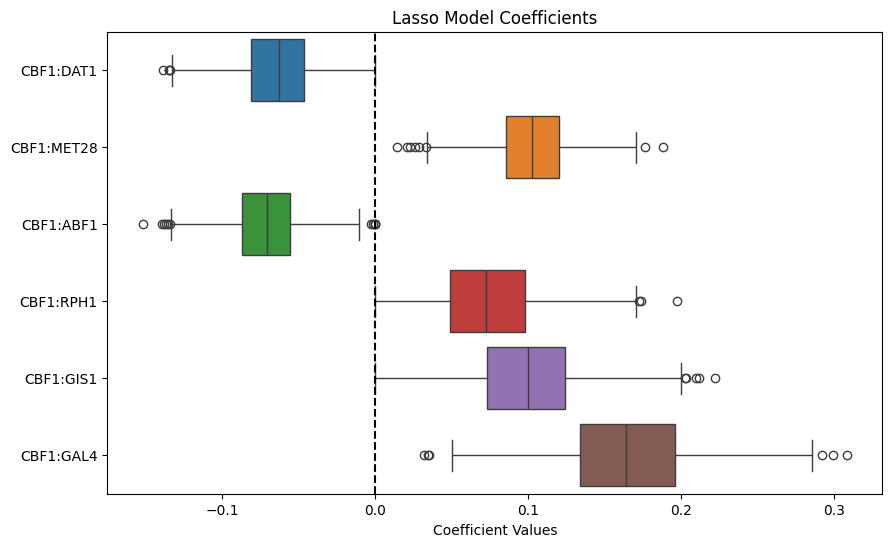

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

res = [int(k.replace("coef_", "")) for k, v in lasso_model[1].items() if v[0] > 0 or v[1] < 0]

for i in res:
    print(f"{cbf1_X.columns[i]}: {lasso_model[1]['coef_' + str(i)]}")

df = pd.DataFrame(lasso_model_raw[1], columns=cbf1_X.columns)

# Extract the columns using the indices in res
df_extracted = df.iloc[:, res]

# Create a boxplot with Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_extracted, orient='h')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Coefficient Values')
plt.title('Lasso Model Coefficients')
plt.show()